<a href="https://colab.research.google.com/github/khanhdang/Spike-MCryptCores/blob/main/aes_snn_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup for the flow


## Install various Python modules

In [ ]:
!pip install spikingjelly
!pip install gdown
!pip install onnxruntime

## Download the training data and the training labels

In [ ]:
!gdown --id 1ujWdxWxGRswGPH7DPnaVpNlpxTX6jA9Y
!gdown --id 14cN-RtGb1yTSdMsYMWgt6VoWf-PNJjbI

Downloading...
From: https://drive.google.com/uc?id=1ujWdxWxGRswGPH7DPnaVpNlpxTX6jA9Y
To: /content/data_training.csv
100% 87.3k/87.3k [00:00<00:00, 8.62MB/s]
Downloading...
From: https://drive.google.com/uc?id=14cN-RtGb1yTSdMsYMWgt6VoWf-PNJjbI
To: /content/output.csv
100% 9.89k/9.89k [00:00<00:00, 16.4MB/s]


## Define the Dataset and the Dataloader

In [ ]:
import numpy as np
import pandas as pd
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
class AESDataset(Dataset):
    def __init__(self, data_path, label_path,max_values,min_values):
        # Transforms
        self.to_tensor = transforms.ToTensor()
    # Read the csv file
        self.data = pd.read_csv(data_path, header=None)
        self.label = pd.read_csv(label_path, header=None)
        self.data = self.data.to_numpy() 
        for i in range(self.data.shape[0]):
            # max_val = self.data[i][:].max()
            # min_val = self.data[i][:].min()
            max_val = max_values[i]
            min_val = min_values[i]
            self.data[i][:] = (self.data[i][:] - min_val) / (max_val - min_val)
        self.label = self.label.to_numpy()
        self.data_len = self.data.shape[1]

    def __getitem__(self, index):
        # Get image name from the pandas df
        return (self.data[:, index].astype(np.float32), self.label[:, index][0].astype(np.long))

    def __len__(self):
        return self.data_len

def get_loader(batch_size,max_values,min_values):
    validation_split = .2
    shuffle_dataset = True
    random_seed = 50 
    dataset = AESDataset('data_training.csv', 'output.csv', max_values,min_values)
    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]
    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset,
                                               sampler=train_sampler, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(dataset,
                                              sampler=test_sampler, batch_size=batch_size)
    return train_loader, test_loader

# Use spikingjelly to train ANN and convert to SNN

## Various Imports for Spikingjelly

In [ ]:
import matplotlib.pyplot as plt
import os
import spikingjelly.clock_driven.ann2snn.examples.utils as utils
import torch
import torch.nn as nn
from spikingjelly.clock_driven.ann2snn import classify_simulator, parser

## Define ANN model (i.e., Fully-Connected 8 - 5 - 11)

In [ ]:
class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8, 5),
            nn.ReLU(),
            nn.Linear(5, 11)
        )
    def forward(self, x):
        x = self.network(x)
        return x

## Settings for log dir, training settings, etc

In [ ]:
log_dir = "./aes_fc"
torch.random.manual_seed(0)
torch.cuda.manual_seed(0)
train_device = "cpu"
parser_device = "cpu"
simulator_device = parser_device
batch_size = 64
learning_rate = 1e-1
T = 20
train_epoch = 100
model_name = "aes_fc"
load = False
if log_dir == None:
    from datetime import datetime
    current_time = datetime.now().strftime('%b%d_%H-%M-%S')
    log_dir = model_name + '-' + current_time
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
else:
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    if not os.path.exists(os.path.join(log_dir, model_name + '.pkl')):
        print('%s has no model to load.' % (log_dir))
        load = False
    else:
        load = True

## Train ANN models

In [ ]:
# initialize data loader
max_values = [100,100,100,100,100,100,100,8]
min_values = [0,0,0,0,-100,-100,-100,-8]
train_data_loader, test_data_loader = get_loader(batch_size,max_values,min_values)
ann = ANN().to(train_device)
loss_function = nn.CrossEntropyLoss()
load=False
if not load:
    print("a")
    optimizer = torch.optim.Adam(
        ann.parameters(), lr=learning_rate, weight_decay=5e-4)
    best_acc = 0.0
    for epoch in range(train_epoch):
        utils.train_ann(net=ann,
                        device=train_device,
                        data_loader=train_data_loader,
                        optimizer=optimizer,
                        loss_function=loss_function,
                        epoch=epoch
                        )
        acc = utils.val_ann(net=ann,
                            device=train_device,
                            data_loader=test_data_loader,
                            loss_function=loss_function,
                            epoch=epoch
                            )
        if best_acc <= acc:
            utils.save_model(ann, log_dir, model_name + '.pkl')
ann = torch.load(os.path.join(log_dir, model_name + '.pkl'))
print('validating best model...')
ann_acc = utils.val_ann(net=ann,
                        device=train_device,
                        data_loader=test_data_loader,
                        loss_function=loss_function
                        )
print(ann_acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


a
Epoch 0 [1/5] ANN Training Loss:2.311 Accuracy:0.260


100%|██████████| 2/2 [00:00<00:00, 253.36it/s]


Epoch 0 [2/2] ANN Validating Loss:1.925 Accuracy:0.527
Save model to: ./aes_fc/aes_fc.pkl
Epoch 1 [1/5] ANN Training Loss:1.892 Accuracy:0.533


100%|██████████| 2/2 [00:00<00:00, 285.76it/s]


Epoch 1 [2/2] ANN Validating Loss:1.471 Accuracy:0.527
Save model to: ./aes_fc/aes_fc.pkl
Epoch 2 [1/5] ANN Training Loss:1.554 Accuracy:0.526


100%|██████████| 2/2 [00:00<00:00, 403.10it/s]


Epoch 2 [2/2] ANN Validating Loss:1.277 Accuracy:0.521
Save model to: ./aes_fc/aes_fc.pkl
Epoch 3 [1/5] ANN Training Loss:1.356 Accuracy:0.476


100%|██████████| 2/2 [00:00<00:00, 255.45it/s]


Epoch 3 [2/2] ANN Validating Loss:1.361 Accuracy:0.521
Save model to: ./aes_fc/aes_fc.pkl
Epoch 4 [1/5] ANN Training Loss:1.157 Accuracy:0.544


100%|██████████| 2/2 [00:00<00:00, 203.44it/s]


Epoch 4 [2/2] ANN Validating Loss:1.075 Accuracy:0.603
Save model to: ./aes_fc/aes_fc.pkl
Epoch 5 [1/5] ANN Training Loss:1.046 Accuracy:0.567


100%|██████████| 2/2 [00:00<00:00, 273.24it/s]


Epoch 5 [2/2] ANN Validating Loss:0.940 Accuracy:0.623
Save model to: ./aes_fc/aes_fc.pkl
Epoch 6 [1/5] ANN Training Loss:1.001 Accuracy:0.613


100%|██████████| 2/2 [00:00<00:00, 286.42it/s]


Epoch 6 [2/2] ANN Validating Loss:0.907 Accuracy:0.615
Save model to: ./aes_fc/aes_fc.pkl
Epoch 7 [1/5] ANN Training Loss:0.927 Accuracy:0.629


100%|██████████| 2/2 [00:00<00:00, 275.23it/s]


Epoch 7 [2/2] ANN Validating Loss:0.858 Accuracy:0.653
Save model to: ./aes_fc/aes_fc.pkl
Epoch 8 [1/5] ANN Training Loss:0.880 Accuracy:0.642


100%|██████████| 2/2 [00:00<00:00, 400.87it/s]


Epoch 8 [2/2] ANN Validating Loss:0.826 Accuracy:0.686
Save model to: ./aes_fc/aes_fc.pkl
Epoch 9 [1/5] ANN Training Loss:0.725 Accuracy:0.679


100%|██████████| 2/2 [00:00<00:00, 266.69it/s]

Epoch 9 [2/2] ANN Validating Loss:0.703 Accuracy:0.745
Save model to: ./aes_fc/aes_fc.pkl


Epoch 10 [1/5] ANN Training Loss:0.710 Accuracy:0.774


100%|██████████| 2/2 [00:00<00:00, 261.99it/s]


Epoch 10 [2/2] ANN Validating Loss:0.649 Accuracy:0.682
Save model to: ./aes_fc/aes_fc.pkl
Epoch 11 [1/5] ANN Training Loss:0.688 Accuracy:0.681


100%|██████████| 2/2 [00:00<00:00, 256.45it/s]


Epoch 11 [2/2] ANN Validating Loss:0.582 Accuracy:0.822
Save model to: ./aes_fc/aes_fc.pkl
Epoch 12 [1/5] ANN Training Loss:0.638 Accuracy:0.859


100%|██████████| 2/2 [00:00<00:00, 348.67it/s]


Epoch 12 [2/2] ANN Validating Loss:0.571 Accuracy:0.801
Save model to: ./aes_fc/aes_fc.pkl
Epoch 13 [1/5] ANN Training Loss:0.609 Accuracy:0.802


100%|██████████| 2/2 [00:00<00:00, 205.58it/s]


Epoch 13 [2/2] ANN Validating Loss:0.477 Accuracy:0.881
Save model to: ./aes_fc/aes_fc.pkl
Epoch 14 [1/5] ANN Training Loss:0.597 Accuracy:0.875


100%|██████████| 2/2 [00:00<00:00, 385.10it/s]

Epoch 14 [2/2] ANN Validating Loss:0.501 Accuracy:0.824


Save model to: ./aes_fc/aes_fc.pkl
Epoch 15 [1/5] ANN Training Loss:0.535 Accuracy:0.818


100%|██████████| 2/2 [00:00<00:00, 273.49it/s]


Epoch 15 [2/2] ANN Validating Loss:0.474 Accuracy:0.889
Save model to: ./aes_fc/aes_fc.pkl
Epoch 16 [1/5] ANN Training Loss:0.535 Accuracy:0.891


100%|██████████| 2/2 [00:00<00:00, 313.58it/s]


Epoch 16 [2/2] ANN Validating Loss:0.429 Accuracy:0.893
Save model to: ./aes_fc/aes_fc.pkl
Epoch 17 [1/5] ANN Training Loss:0.497 Accuracy:0.909


100%|██████████| 2/2 [00:00<00:00, 220.08it/s]


Epoch 17 [2/2] ANN Validating Loss:0.477 Accuracy:0.902
Save model to: ./aes_fc/aes_fc.pkl
Epoch 18 [1/5] ANN Training Loss:0.508 Accuracy:0.888


100%|██████████| 2/2 [00:00<00:00, 355.60it/s]


Epoch 18 [2/2] ANN Validating Loss:0.457 Accuracy:0.851
Save model to: ./aes_fc/aes_fc.pkl
Epoch 19 [1/5] ANN Training Loss:0.451 Accuracy:0.870


100%|██████████| 2/2 [00:00<00:00, 184.36it/s]


Epoch 19 [2/2] ANN Validating Loss:0.404 Accuracy:0.912
Save model to: ./aes_fc/aes_fc.pkl
Epoch 20 [1/5] ANN Training Loss:0.408 Accuracy:0.902


100%|██████████| 2/2 [00:00<00:00, 288.62it/s]


Epoch 20 [2/2] ANN Validating Loss:0.393 Accuracy:0.948
Save model to: ./aes_fc/aes_fc.pkl
Epoch 21 [1/5] ANN Training Loss:0.409 Accuracy:0.941


100%|██████████| 2/2 [00:00<00:00, 258.89it/s]


Epoch 21 [2/2] ANN Validating Loss:0.405 Accuracy:0.877
Save model to: ./aes_fc/aes_fc.pkl
Epoch 22 [1/5] ANN Training Loss:0.392 Accuracy:0.902


100%|██████████| 2/2 [00:00<00:00, 253.00it/s]


Epoch 22 [2/2] ANN Validating Loss:0.324 Accuracy:0.929
Save model to: ./aes_fc/aes_fc.pkl
Epoch 23 [1/5] ANN Training Loss:0.365 Accuracy:0.941


100%|██████████| 2/2 [00:00<00:00, 223.70it/s]


Epoch 23 [2/2] ANN Validating Loss:0.383 Accuracy:0.939
Save model to: ./aes_fc/aes_fc.pkl
Epoch 24 [1/5] ANN Training Loss:0.419 Accuracy:0.920


100%|██████████| 2/2 [00:00<00:00, 186.55it/s]


Epoch 24 [2/2] ANN Validating Loss:0.340 Accuracy:0.937
Save model to: ./aes_fc/aes_fc.pkl
Epoch 25 [1/5] ANN Training Loss:0.366 Accuracy:0.932


100%|██████████| 2/2 [00:00<00:00, 228.67it/s]


Epoch 25 [2/2] ANN Validating Loss:0.309 Accuracy:0.939
Save model to: ./aes_fc/aes_fc.pkl
Epoch 26 [1/5] ANN Training Loss:0.329 Accuracy:0.929


100%|██████████| 2/2 [00:00<00:00, 169.52it/s]


Epoch 26 [2/2] ANN Validating Loss:0.316 Accuracy:0.954
Save model to: ./aes_fc/aes_fc.pkl
Epoch 27 [1/5] ANN Training Loss:0.294 Accuracy:0.966


100%|██████████| 2/2 [00:00<00:00, 224.01it/s]


Epoch 27 [2/2] ANN Validating Loss:0.348 Accuracy:0.935
Save model to: ./aes_fc/aes_fc.pkl
Epoch 28 [1/5] ANN Training Loss:0.308 Accuracy:0.952


100%|██████████| 2/2 [00:00<00:00, 209.92it/s]


Epoch 28 [2/2] ANN Validating Loss:0.294 Accuracy:0.952
Save model to: ./aes_fc/aes_fc.pkl
Epoch 29 [1/5] ANN Training Loss:0.289 Accuracy:0.950


100%|██████████| 2/2 [00:00<00:00, 218.97it/s]

Epoch 29 [2/2] ANN Validating Loss:0.297 Accuracy:0.985
Save model to: ./aes_fc/aes_fc.pkl
Epoch 30 [1/5] ANN Training Loss:0.272 Accuracy:0.993



100%|██████████| 2/2 [00:00<00:00, 215.51it/s]


Epoch 30 [2/2] ANN Validating Loss:0.282 Accuracy:0.958
Save model to: ./aes_fc/aes_fc.pkl
Epoch 31 [1/5] ANN Training Loss:0.270 Accuracy:0.973


100%|██████████| 2/2 [00:00<00:00, 134.43it/s]

Epoch 31 [2/2] ANN Validating Loss:0.274 Accuracy:0.960
Save model to: ./aes_fc/aes_fc.pkl


Epoch 32 [1/5] ANN Training Loss:0.256 Accuracy:0.970


100%|██████████| 2/2 [00:00<00:00, 202.71it/s]


Epoch 32 [2/2] ANN Validating Loss:0.267 Accuracy:0.950
Save model to: ./aes_fc/aes_fc.pkl
Epoch 33 [1/5] ANN Training Loss:0.249 Accuracy:0.952


100%|██████████| 2/2 [00:00<00:00, 194.62it/s]


Epoch 33 [2/2] ANN Validating Loss:0.230 Accuracy:0.962
Save model to: ./aes_fc/aes_fc.pkl
Epoch 34 [1/5] ANN Training Loss:0.248 Accuracy:0.959


100%|██████████| 2/2 [00:00<00:00, 201.46it/s]


Epoch 34 [2/2] ANN Validating Loss:0.270 Accuracy:0.956
Save model to: ./aes_fc/aes_fc.pkl
Epoch 35 [1/5] ANN Training Loss:0.245 Accuracy:0.954


100%|██████████| 2/2 [00:00<00:00, 189.65it/s]


Epoch 35 [2/2] ANN Validating Loss:0.218 Accuracy:0.964
Save model to: ./aes_fc/aes_fc.pkl
Epoch 36 [1/5] ANN Training Loss:0.233 Accuracy:0.957


100%|██████████| 2/2 [00:00<00:00, 206.66it/s]


Epoch 36 [2/2] ANN Validating Loss:0.247 Accuracy:0.979
Save model to: ./aes_fc/aes_fc.pkl
Epoch 37 [1/5] ANN Training Loss:0.244 Accuracy:0.975


100%|██████████| 2/2 [00:00<00:00, 216.13it/s]


Epoch 37 [2/2] ANN Validating Loss:0.215 Accuracy:0.964
Save model to: ./aes_fc/aes_fc.pkl
Epoch 38 [1/5] ANN Training Loss:0.236 Accuracy:0.973


100%|██████████| 2/2 [00:00<00:00, 221.08it/s]

Epoch 38 [2/2] ANN Validating Loss:0.241 Accuracy:0.992
Save model to: ./aes_fc/aes_fc.pkl


Epoch 39 [1/5] ANN Training Loss:0.232 Accuracy:1.000


100%|██████████| 2/2 [00:00<00:00, 201.80it/s]

Epoch 39 [2/2] ANN Validating Loss:0.255 Accuracy:0.962
Save model to: ./aes_fc/aes_fc.pkl
Epoch 40 [1/5] ANN Training Loss:0.236 Accuracy:0.961

100%|██████████| 2/2 [00:00<00:00, 211.85it/s]


Epoch 40 [2/2] ANN Validating Loss:0.253 Accuracy:0.964
Save model to: ./aes_fc/aes_fc.pkl
Epoch 41 [1/5] ANN Training Loss:0.202 Accuracy:0.968


100%|██████████| 2/2 [00:00<00:00, 183.43it/s]

Epoch 41 [2/2] ANN Validating Loss:0.208 Accuracy:0.992
Save model to: ./aes_fc/aes_fc.pkl
Epoch 42 [1/5] ANN Training Loss:0.201 Accuracy:0.993



100%|██████████| 2/2 [00:00<00:00, 223.99it/s]


Epoch 42 [2/2] ANN Validating Loss:0.216 Accuracy:0.952
Save model to: ./aes_fc/aes_fc.pkl
Epoch 43 [1/5] ANN Training Loss:0.221 Accuracy:0.948


100%|██████████| 2/2 [00:00<00:00, 210.69it/s]


Epoch 43 [2/2] ANN Validating Loss:0.166 Accuracy:0.979
Save model to: ./aes_fc/aes_fc.pkl
Epoch 44 [1/5] ANN Training Loss:0.193 Accuracy:0.975


100%|██████████| 2/2 [00:00<00:00, 225.50it/s]


Epoch 44 [2/2] ANN Validating Loss:0.200 Accuracy:0.987
Save model to: ./aes_fc/aes_fc.pkl
Epoch 45 [1/5] ANN Training Loss:0.183 Accuracy:0.991


100%|██████████| 2/2 [00:00<00:00, 84.17it/s]


Epoch 45 [2/2] ANN Validating Loss:0.194 Accuracy:0.952
Save model to: ./aes_fc/aes_fc.pkl
Epoch 46 [1/5] ANN Training Loss:0.197 Accuracy:0.950


100%|██████████| 2/2 [00:00<00:00, 220.40it/s]


Epoch 46 [2/2] ANN Validating Loss:0.187 Accuracy:0.975
Save model to: ./aes_fc/aes_fc.pkl
Epoch 47 [1/5] ANN Training Loss:0.173 Accuracy:0.989


100%|██████████| 2/2 [00:00<00:00, 184.43it/s]


Epoch 47 [2/2] ANN Validating Loss:0.243 Accuracy:0.983
Save model to: ./aes_fc/aes_fc.pkl
Epoch 48 [1/5] ANN Training Loss:0.203 Accuracy:0.991


100%|██████████| 2/2 [00:00<00:00, 208.27it/s]


Epoch 48 [2/2] ANN Validating Loss:0.197 Accuracy:0.944
Save model to: ./aes_fc/aes_fc.pkl
Epoch 49 [1/5] ANN Training Loss:0.218 Accuracy:0.954


100%|██████████| 2/2 [00:00<00:00, 217.89it/s]


Epoch 49 [2/2] ANN Validating Loss:0.234 Accuracy:0.990
Save model to: ./aes_fc/aes_fc.pkl
Epoch 50 [1/5] ANN Training Loss:0.221 Accuracy:0.995


100%|██████████| 2/2 [00:00<00:00, 173.14it/s]


Epoch 50 [2/2] ANN Validating Loss:0.182 Accuracy:0.990
Save model to: ./aes_fc/aes_fc.pkl
Epoch 51 [1/5] ANN Training Loss:0.184 Accuracy:0.993


100%|██████████| 2/2 [00:00<00:00, 126.76it/s]


Epoch 51 [2/2] ANN Validating Loss:0.205 Accuracy:0.971
Save model to: ./aes_fc/aes_fc.pkl
Epoch 52 [1/5] ANN Training Loss:0.188 Accuracy:0.973


100%|██████████| 2/2 [00:00<00:00, 163.94it/s]


Epoch 52 [2/2] ANN Validating Loss:0.170 Accuracy:0.977
Save model to: ./aes_fc/aes_fc.pkl
Epoch 53 [1/5] ANN Training Loss:0.186 Accuracy:0.973


100%|██████████| 2/2 [00:00<00:00, 60.32it/s]


Epoch 53 [2/2] ANN Validating Loss:0.176 Accuracy:0.954
Save model to: ./aes_fc/aes_fc.pkl
Epoch 54 [1/5] ANN Training Loss:0.202 Accuracy:0.961


100%|██████████| 2/2 [00:00<00:00, 223.38it/s]


Epoch 54 [2/2] ANN Validating Loss:0.186 Accuracy:0.981
Save model to: ./aes_fc/aes_fc.pkl
Epoch 55 [1/5] ANN Training Loss:0.178 Accuracy:0.984


100%|██████████| 2/2 [00:00<00:00, 230.21it/s]


Epoch 55 [2/2] ANN Validating Loss:0.197 Accuracy:0.956
Save model to: ./aes_fc/aes_fc.pkl
Epoch 56 [1/5] ANN Training Loss:0.188 Accuracy:0.959


100%|██████████| 2/2 [00:00<00:00, 229.63it/s]


Epoch 56 [2/2] ANN Validating Loss:0.173 Accuracy:0.975
Save model to: ./aes_fc/aes_fc.pkl
Epoch 57 [1/5] ANN Training Loss:0.183 Accuracy:0.975


100%|██████████| 2/2 [00:00<00:00, 155.30it/s]


Epoch 57 [2/2] ANN Validating Loss:0.166 Accuracy:0.958
Save model to: ./aes_fc/aes_fc.pkl
Epoch 58 [1/5] ANN Training Loss:0.172 Accuracy:0.961


100%|██████████| 2/2 [00:00<00:00, 208.30it/s]


Epoch 58 [2/2] ANN Validating Loss:0.189 Accuracy:0.996
Save model to: ./aes_fc/aes_fc.pkl
Epoch 59 [1/5] ANN Training Loss:0.154 Accuracy:0.998


100%|██████████| 2/2 [00:00<00:00, 170.20it/s]

Epoch 59 [2/2] ANN Validating Loss:0.199 Accuracy:0.971
Save model to: ./aes_fc/aes_fc.pkl


Epoch 60 [1/5] ANN Training Loss:0.181 Accuracy:0.970


100%|██████████| 2/2 [00:00<00:00, 165.47it/s]


Epoch 60 [2/2] ANN Validating Loss:0.152 Accuracy:0.994
Save model to: ./aes_fc/aes_fc.pkl
Epoch 61 [1/5] ANN Training Loss:0.136 Accuracy:1.000


100%|██████████| 2/2 [00:00<00:00, 185.49it/s]


Epoch 61 [2/2] ANN Validating Loss:0.149 Accuracy:0.975
Save model to: ./aes_fc/aes_fc.pkl
Epoch 62 [1/5] ANN Training Loss:0.149 Accuracy:0.984


100%|██████████| 2/2 [00:00<00:00, 210.00it/s]

Epoch 62 [2/2] ANN Validating Loss:0.176 Accuracy:0.996


Save model to: ./aes_fc/aes_fc.pkl
Epoch 63 [1/5] ANN Training Loss:0.153 Accuracy:0.995


100%|██████████| 2/2 [00:00<00:00, 159.65it/s]


Epoch 63 [2/2] ANN Validating Loss:0.156 Accuracy:0.998
Save model to: ./aes_fc/aes_fc.pkl
Epoch 64 [1/5] ANN Training Loss:0.141 Accuracy:0.998


100%|██████████| 2/2 [00:00<00:00, 201.63it/s]


Epoch 64 [2/2] ANN Validating Loss:0.157 Accuracy:0.998
Save model to: ./aes_fc/aes_fc.pkl
Epoch 65 [1/5] ANN Training Loss:0.148 Accuracy:1.000


100%|██████████| 2/2 [00:00<00:00, 143.40it/s]


Epoch 65 [2/2] ANN Validating Loss:0.202 Accuracy:0.956
Save model to: ./aes_fc/aes_fc.pkl
Epoch 66 [1/5] ANN Training Loss:0.158 Accuracy:0.954


100%|██████████| 2/2 [00:00<00:00, 247.23it/s]


Epoch 66 [2/2] ANN Validating Loss:0.149 Accuracy:0.996
Save model to: ./aes_fc/aes_fc.pkl
Epoch 67 [1/5] ANN Training Loss:0.140 Accuracy:0.995


100%|██████████| 2/2 [00:00<00:00, 224.61it/s]


Epoch 67 [2/2] ANN Validating Loss:0.150 Accuracy:0.998
Save model to: ./aes_fc/aes_fc.pkl
Epoch 68 [1/5] ANN Training Loss:0.144 Accuracy:0.998


100%|██████████| 2/2 [00:00<00:00, 224.34it/s]


Epoch 68 [2/2] ANN Validating Loss:0.153 Accuracy:0.998
Save model to: ./aes_fc/aes_fc.pkl
Epoch 69 [1/5] ANN Training Loss:0.138 Accuracy:0.995


100%|██████████| 2/2 [00:00<00:00, 236.12it/s]


Epoch 69 [2/2] ANN Validating Loss:0.131 Accuracy:0.975
Save model to: ./aes_fc/aes_fc.pkl
Epoch 70 [1/5] ANN Training Loss:0.155 Accuracy:0.979


100%|██████████| 2/2 [00:00<00:00, 79.45it/s]


Epoch 70 [2/2] ANN Validating Loss:0.143 Accuracy:0.983
Save model to: ./aes_fc/aes_fc.pkl
Epoch 71 [1/5] ANN Training Loss:0.138 Accuracy:0.982


100%|██████████| 2/2 [00:00<00:00, 82.19it/s]


Epoch 71 [2/2] ANN Validating Loss:0.144 Accuracy:1.000
Save model to: ./aes_fc/aes_fc.pkl
Epoch 72 [1/5] ANN Training Loss:0.131 Accuracy:1.000


100%|██████████| 2/2 [00:00<00:00, 123.40it/s]


Epoch 72 [2/2] ANN Validating Loss:0.148 Accuracy:0.987
Save model to: ./aes_fc/aes_fc.pkl
Epoch 73 [1/5] ANN Training Loss:0.142 Accuracy:0.993


100%|██████████| 2/2 [00:00<00:00, 12.79it/s]


Epoch 73 [2/2] ANN Validating Loss:0.117 Accuracy:0.983
Save model to: ./aes_fc/aes_fc.pkl
Epoch 74 [1/5] ANN Training Loss:0.137 Accuracy:0.984


100%|██████████| 2/2 [00:00<00:00, 219.21it/s]


Epoch 74 [2/2] ANN Validating Loss:0.126 Accuracy:1.000
Save model to: ./aes_fc/aes_fc.pkl
Epoch 75 [1/5] ANN Training Loss:0.142 Accuracy:1.000


100%|██████████| 2/2 [00:00<00:00, 193.47it/s]


Epoch 75 [2/2] ANN Validating Loss:0.131 Accuracy:1.000
Save model to: ./aes_fc/aes_fc.pkl
Epoch 76 [1/5] ANN Training Loss:0.130 Accuracy:0.998


100%|██████████| 2/2 [00:00<00:00, 227.90it/s]


Epoch 76 [2/2] ANN Validating Loss:0.132 Accuracy:0.981
Save model to: ./aes_fc/aes_fc.pkl
Epoch 77 [1/5] ANN Training Loss:0.137 Accuracy:0.973


100%|██████████| 2/2 [00:00<00:00, 211.31it/s]


Epoch 77 [2/2] ANN Validating Loss:0.141 Accuracy:1.000
Save model to: ./aes_fc/aes_fc.pkl
Epoch 78 [1/5] ANN Training Loss:0.130 Accuracy:1.000


100%|██████████| 2/2 [00:00<00:00, 227.65it/s]


Epoch 78 [2/2] ANN Validating Loss:0.154 Accuracy:1.000
Save model to: ./aes_fc/aes_fc.pkl
Epoch 79 [1/5] ANN Training Loss:0.119 Accuracy:0.998


100%|██████████| 2/2 [00:00<00:00, 84.49it/s]


Epoch 79 [2/2] ANN Validating Loss:0.135 Accuracy:0.977
Save model to: ./aes_fc/aes_fc.pkl
Epoch 80 [1/5] ANN Training Loss:0.134 Accuracy:0.979


100%|██████████| 2/2 [00:00<00:00, 227.38it/s]


Epoch 80 [2/2] ANN Validating Loss:0.128 Accuracy:0.987
Save model to: ./aes_fc/aes_fc.pkl
Epoch 81 [1/5] ANN Training Loss:0.136 Accuracy:0.989


100%|██████████| 2/2 [00:00<00:00, 176.88it/s]


Epoch 81 [2/2] ANN Validating Loss:0.120 Accuracy:1.000
Save model to: ./aes_fc/aes_fc.pkl
Epoch 82 [1/5] ANN Training Loss:0.128 Accuracy:1.000


100%|██████████| 2/2 [00:00<00:00, 182.07it/s]


Epoch 82 [2/2] ANN Validating Loss:0.153 Accuracy:0.998
Save model to: ./aes_fc/aes_fc.pkl
Epoch 83 [1/5] ANN Training Loss:0.147 Accuracy:0.998


100%|██████████| 2/2 [00:00<00:00, 167.87it/s]


Epoch 83 [2/2] ANN Validating Loss:0.144 Accuracy:0.964
Save model to: ./aes_fc/aes_fc.pkl
Epoch 84 [1/5] ANN Training Loss:0.139 Accuracy:0.964


100%|██████████| 2/2 [00:00<00:00, 178.11it/s]


Epoch 84 [2/2] ANN Validating Loss:0.144 Accuracy:1.000
Save model to: ./aes_fc/aes_fc.pkl
Epoch 85 [1/5] ANN Training Loss:0.142 Accuracy:1.000


100%|██████████| 2/2 [00:00<00:00, 217.35it/s]


Epoch 85 [2/2] ANN Validating Loss:0.120 Accuracy:0.996
Save model to: ./aes_fc/aes_fc.pkl
Epoch 86 [1/5] ANN Training Loss:0.140 Accuracy:1.000


100%|██████████| 2/2 [00:00<00:00, 203.13it/s]


Epoch 86 [2/2] ANN Validating Loss:0.123 Accuracy:1.000
Save model to: ./aes_fc/aes_fc.pkl
Epoch 87 [1/5] ANN Training Loss:0.133 Accuracy:1.000


100%|██████████| 2/2 [00:00<00:00, 153.86it/s]


Epoch 87 [2/2] ANN Validating Loss:0.123 Accuracy:0.977
Save model to: ./aes_fc/aes_fc.pkl
Epoch 88 [1/5] ANN Training Loss:0.144 Accuracy:0.982


100%|██████████| 2/2 [00:00<00:00, 225.07it/s]


Epoch 88 [2/2] ANN Validating Loss:0.122 Accuracy:1.000
Save model to: ./aes_fc/aes_fc.pkl
Epoch 89 [1/5] ANN Training Loss:0.139 Accuracy:0.995


100%|██████████| 2/2 [00:00<00:00, 106.70it/s]


Epoch 89 [2/2] ANN Validating Loss:0.158 Accuracy:1.000
Save model to: ./aes_fc/aes_fc.pkl
Epoch 90 [1/5] ANN Training Loss:0.141 Accuracy:1.000


100%|██████████| 2/2 [00:00<00:00, 215.56it/s]


Epoch 90 [2/2] ANN Validating Loss:0.116 Accuracy:1.000
Save model to: ./aes_fc/aes_fc.pkl
Epoch 91 [1/5] ANN Training Loss:0.120 Accuracy:1.000


100%|██████████| 2/2 [00:00<00:00, 124.41it/s]


Epoch 91 [2/2] ANN Validating Loss:0.138 Accuracy:0.979
Save model to: ./aes_fc/aes_fc.pkl
Epoch 92 [1/5] ANN Training Loss:0.133 Accuracy:0.982


100%|██████████| 2/2 [00:00<00:00, 221.04it/s]

Epoch 92 [2/2] ANN Validating Loss:0.133 Accuracy:0.998
Save model to: ./aes_fc/aes_fc.pkl


Epoch 93 [1/5] ANN Training Loss:0.128 Accuracy:0.995


100%|██████████| 2/2 [00:00<00:00, 221.90it/s]


Epoch 93 [2/2] ANN Validating Loss:0.118 Accuracy:1.000
Save model to: ./aes_fc/aes_fc.pkl
Epoch 94 [1/5] ANN Training Loss:0.131 Accuracy:1.000


100%|██████████| 2/2 [00:00<00:00, 192.91it/s]


Epoch 94 [2/2] ANN Validating Loss:0.166 Accuracy:0.977
Save model to: ./aes_fc/aes_fc.pkl
Epoch 95 [1/5] ANN Training Loss:0.118 Accuracy:0.984


100%|██████████| 2/2 [00:00<00:00, 191.35it/s]

Epoch 95 [2/2] ANN Validating Loss:0.113 Accuracy:1.000
Save model to: ./aes_fc/aes_fc.pkl


Epoch 96 [1/5] ANN Training Loss:0.137 Accuracy:0.998


100%|██████████| 2/2 [00:00<00:00, 95.89it/s]


Epoch 96 [2/2] ANN Validating Loss:0.139 Accuracy:1.000
Save model to: ./aes_fc/aes_fc.pkl
Epoch 97 [1/5] ANN Training Loss:0.125 Accuracy:1.000


100%|██████████| 2/2 [00:00<00:00, 149.93it/s]

Epoch 97 [2/2] ANN Validating Loss:0.124 Accuracy:1.000
Save model to: ./aes_fc/aes_fc.pkl


Epoch 98 [1/5] ANN Training Loss:0.128 Accuracy:1.000


100%|██████████| 2/2 [00:00<00:00, 160.44it/s]


Epoch 98 [2/2] ANN Validating Loss:0.137 Accuracy:0.977
Save model to: ./aes_fc/aes_fc.pkl
Epoch 99 [1/5] ANN Training Loss:0.128 Accuracy:0.986


100%|██████████| 2/2 [00:00<00:00, 196.65it/s]


Epoch 99 [2/2] ANN Validating Loss:0.125 Accuracy:0.994
Save model to: ./aes_fc/aes_fc.pkl
validating best model...


100%|██████████| 2/2 [00:00<00:00, 169.65it/s]


ANN Validating Accuracy:0.994
0.9937238493723849


## Convert to SNN using Spiking Jelly

In [ ]:
percentage = 0.004  # load 0.004 of the data
norm_data_list = []
for idx, (imgs, targets) in enumerate(train_data_loader):
    norm_data_list.append(imgs)
    if idx == int(len(train_data_loader) * percentage) - 1:
        break
norm_data = torch.cat(norm_data_list)
print('use %d imgs to parse' % (norm_data.size(0)))

# 调用parser，使用kernel为onnx
# Call parser, use onnx kernel
onnxparser = parser(name=model_name,
                    log_dir=log_dir + '/parser',
                    kernel='onnx')
#     ann = pytorch_kernel.layer_reduction(ann)
snn = onnxparser.parse(ann, norm_data.to(parser_device))

# Save SNN model
torch.save(snn, os.path.join(log_dir, 'snn-' + model_name + '.pkl'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


use 1914 imgs to parse
parser log_dir: ./aes_fc/parser

Getting intermediate output statistics...



100%|██████████| 4/4 [00:00<00:00, 427.40it/s]


Finished getting intermediate output statistics!

Normalizing model...



100%|██████████| 4/4 [00:00<00:00, 8073.73it/s]

Finished normalizing model!
no user-defined conversion method found, use default


## Run the SNN simulator by Spikingjelly

simulator log_dir: ./aes_fc/simulator
simulator is working on the normal mode, device: cpu


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


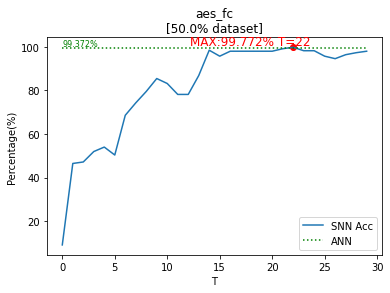

 50%|█████     | 1/2 [00:00<00:00,  4.30it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


<Figure size 432x288 with 0 Axes>

100%|██████████| 2/2 [00:00<00:00,  7.05it/s]

--------------------simulator summary--------------------
time elapsed: 0.28720657699997787 (sec)
---------------------------------------------------------


In [ ]:
fig = plt.figure('simulator')
    # define simulator for classification task
sim = classify_simulator(snn,
                             log_dir=log_dir + '/simulator',
                             device=simulator_device,
                             canvas=fig
                             )
    # Simulate SNN
sim.simulate(test_data_loader,
                 T=T,
                 online_drawer=True,
                 ann_acc=ann_acc,
                 fig_name=model_name,
                 step_max=True
                 )

fig.savefig("graph.pdf")

# Quantization and Tests for RTL models

The spike trains and the membrane potentials of the neurons are saved in their respective list

## Function to quantize

In [ ]:
def fixed_point_quantize(x, wl, fl):
    """ Quantize a single precision Floating Point into low-precision Fixed
    Point

    Args:
        - :param: `x` (torch.Tensor) :  the single precision number to be
          quantized
        - :param: `wl` (int) : word length of the fixed point number being
          simulated
        - :param: `fl` (int) : fractional length of the fixed point number
          being simulated

    Returns:
        - a quantized low-precision block floating point number (torch.Tensor)
          """
    assert isinstance(x, torch.Tensor)
    # Clamp the tensor to range of [-2**(wl-1)/2**fl,2**(wl-1)/2**(wl-1)/2**fl]
    min_val, max_val = -2**(wl-1)/2**fl, (2**(wl-1)-1)/2**fl
    out = torch.clamp(x, min_val, max_val)
    # quantize process
    out = torch.round(out*2**fl)/2**fl
    # assert rounding in ["stochastic", "nearest"]
    return out

In [ ]:
from spikingjelly.clock_driven import neuron
snn = torch.load('./aes_fc/snn-aes_fc.pkl')
batch_size = 439 #set the batch_size to whole testset size
max_values = [100,100,100,100,100,100,100,8]
min_values = [0,0,0,0,-100,-100,-100,-8]
train_loader, test_loader = get_loader(batch_size,max_values,min_values)
test_data, test_label = next(iter(test_loader))
is_quantize = True

T = 30 #number of timestepts
n_fractional = 6

for module in snn.module_list:
    if (isinstance(module, nn.Linear) and is_quantize):
        module.weight.data = fixed_point_quantize(module.weight.data,8,n_fractional) #Quantize to n bit fractional
        module.bias.data = fixed_point_quantize(module.bias.data,16,2*n_fractional) #Quantize to n bit fractional
layer_keys = ["Flatten", "FC1", "IF1", "FC2"]
module_dict = dict(zip(layer_keys, snn.module_list))
if is_quantize:  
  test_data = fixed_point_quantize(test_data,8,n_fractional)
out = {}
membrane_potential = []
spike_list = []
for i in range(T):
    temp = test_data
    for key in module_dict.keys():
        out[key] = module_dict[key](temp)
        if key=="IF1":
            membrane_potential.append(module_dict[key].v)
            # print(module_dict[key].v[0])
            spike_list.append(out[key])
        temp = out[key]
    if i == 0:
        counter = out["FC2"]
    else:
        # print(out["FC2"])
        counter += out["FC2"]
print(counter)
correct = (counter.max(1)[1]==test_label).sum()
diff = (counter.max(1)[1]-test_label).max()
print(diff)
print("Correct= {:.2f}%".format(correct/batch_size*100))

tensor([[-24.1060, -11.6704, -10.8916,  ...,   3.7021,   0.7788,  -5.1294],
        [ -8.6997,   0.5171,   1.6084,  ...,  -4.9541,  -9.6899, -18.8481],
        [-16.4028,  -5.5767,  -4.6416,  ...,  -0.6260,  -4.4556, -11.9888],
        ...,
        [-56.8560, -38.2017, -38.2041,  ...,  22.9521,  24.3726,  26.3081],
        [-57.8247, -39.2798, -39.3604,  ...,  23.9209,  25.7007,  28.3081],
        [-56.8560, -38.2017, -38.2041,  ...,  22.9521,  24.3726,  26.3081]],
       grad_fn=<AddBackward0>)
tensor(1)
Correct= 97.72%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


## Testing with integer weights 

In [ ]:
from spikingjelly.clock_driven import neuron
snn = torch.load('./aes_fc/snn-aes_fc.pkl')
batch_size = 439 #set the batch_size to whole testset size
max_values = [100,100,100,100,100,100,100,8]
min_values = [0,0,0,0,-100,-100,-100,-8]
train_loader, test_loader = get_loader(batch_size,max_values,min_values)
test_data, test_label = next(iter(test_loader))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [ ]:
snn = torch.load('./aes_fc/snn-aes_fc.pkl')
is_quantize = True
T = 30 #number of timestepts
n_fractional = 6

for name, module in snn.named_modules():
    if (isinstance(module, nn.Linear) and is_quantize):
        module.weight.data = fixed_point_quantize(module.weight.data,8,n_fractional)
        if "3" in name: #Quantize to n bit fractional
           module.bias.data = fixed_point_quantize(module.bias.data,8,n_fractional)
        else:
           module.bias.data = fixed_point_quantize(module.bias.data,16,2*n_fractional)
if is_quantize:  
  test_data_new = fixed_point_quantize(test_data,8,n_fractional)
layer_keys = ["Flatten", "FC1", "IF1", "FC2"]
module_dict = dict(zip(layer_keys, snn.module_list))
out = {}
membrane_potential = []
spike_list = []
for i in range(T):
    temp = test_data_new
    for key in module_dict.keys():
        out[key] = module_dict[key](temp)
        if key == "IF1":
            membrane_potential.append(module_dict[key].v)
            spike_list.append(out[key])
            temp = out[key]
        else:
            temp =out[key]
    if i == 0:
        counter = out["FC2"]
    else:
        counter += out["FC2"]
correct = (counter.max(1)[1]==test_label).sum()
diff = (counter.max(1)[1]-test_label).max()
print(diff)
print("Max difference between SNN predictions and labels= "+ str(diff.item()))
diff = (counter.max(1)[1]-test_label).min()
print("Min difference between SNN predictions and labels= "+ str(diff.item()))
print(counter.max(1)[1])
print(counter)
print("Correct= {:.2f}%".format(correct/batch_size*100))

tensor(1)
Max difference between SNN predictions and labels= 1
Min difference between SNN predictions and labels= -1
tensor([ 3,  0,  3,  6, 10,  3,  6,  5,  0,  4, 10,  5, 10,  6,  0, 10,  4,  7,
         7,  7,  0,  1,  5,  5,  5,  3,  4,  4,  3,  6,  4, 10,  0,  5,  4,  3,
         4,  7,  0, 10,  1, 10, 10,  5,  2,  2,  0,  1,  0,  1,  6,  1,  2,  0,
         1,  0,  1,  7,  0,  0,  4,  3,  0,  1,  2,  3,  4,  3, 10,  3,  6, 10,
         0,  0,  5,  5,  4,  4,  2,  5,  3,  0, 10,  0,  5,  2,  5,  1,  0,  0,
         5,  3,  1,  4, 10,  0, 10,  5,  5, 10,  2,  2,  1,  0,  6, 10,  0,  1,
        10,  5,  2,  0,  4,  5,  0,  1, 10,  0, 10,  4,  5, 10, 10,  6,  5,  5,
         1, 10,  0,  3,  5,  1,  7, 10,  0,  5,  5,  5,  5, 10,  2,  5,  1, 10,
        10,  0,  2,  2,  3, 10,  4,  0, 10,  8,  0,  0,  3, 10, 10,  0,  0, 10,
         4,  0,  0,  7,  4,  0, 10,  0, 10,  0, 10,  0,  1,  5,  2,  5,  3, 10,
         4,  0,  4, 10,  0, 10,  0,  0, 10,  3, 10, 10, 10,  6,  0,  4,  4,  8,
   

In [ ]:
snn = torch.load('./aes_fc/snn-aes_fc.pkl')
is_quantize = True
T = 30 #number of timestepts
n_fractional = 6

for name, module in snn.named_modules():
    if (isinstance(module, nn.Linear) and is_quantize):
        module.weight.data = fixed_point_quantize(module.weight.data,8,n_fractional)*2**n_fractional
        if "3" in name: #Quantize to n bit fractional
           module.bias.data = fixed_point_quantize(module.bias.data,8,n_fractional)*2**n_fractional
        else:
           module.bias.data = fixed_point_quantize(module.bias.data,16,2*n_fractional)*2**(2*n_fractional)
    if (isinstance(module,neuron.IFNode)):
        module.v_threshold = module.v_threshold*2**(2*n_fractional)

if is_quantize:  
  test_data_new = fixed_point_quantize(test_data,8,n_fractional)*2**n_fractional
layer_keys = ["Flatten", "FC1", "IF1", "FC2"]
module_dict = dict(zip(layer_keys, snn.module_list))
out = {}
membrane_potential = []
spike_list = []
for i in range(T):
    temp = test_data_new
    for key in module_dict.keys():
        out[key] = module_dict[key](temp)
        if key == "IF1":
            membrane_potential.append(module_dict[key].v)
            # print(module_dict[key].v[0])
            spike_list.append(out[key])
            temp = out[key]
        else:
            temp =out[key]
    if i == 0:
        counter = out["FC2"]
    else:
        counter += out["FC2"]
        # print(out["FC2"])
#print(module_dict['IF1'].v)
correct = (counter.max(1)[1]==test_label).sum()
print(counter)
#print(module_dict['FC1'].weight.data)
#print(spike_list[5][0])
#print(membrane_potential[29][0])
print("Correct= {:.2f}%".format(correct/batch_size*100))

tensor([[   70.,   501.,   586.,  ...,  -646., -1005., -1718.],
        [ 1838.,  1767.,  1556.,  ..., -1550., -2125., -3230.],
        [  -53.,   417.,   502.,  ...,  -595.,  -950., -1657.],
        ...,
        [-1039.,  -363.,  -298.,  ...,   -41.,  -280.,  -779.],
        [-1471.,  -738.,  -688.,  ...,   247.,    85.,  -273.],
        [ 1838.,  1767.,  1556.,  ..., -1550., -2125., -3230.]],
       grad_fn=<AddBackward0>)
Correct= 95.44%


## Extract weights, bias, and inputs for testing

In [ ]:
for key in module_dict.keys():
  if (isinstance(module_dict[key],nn.Linear)):
    filename_weight = key + "_weight.txt"
    filename_bias = key +"_bias.txt"
    weight = module_dict[key].weight.data.numpy()
    weight = np.reshape(weight,(-1,1))
    #print(weight)
    np.savetxt(filename_weight,weight,fmt="%d")
    bias = module_dict[key].bias.data.numpy()
    bias = np.reshape(bias,(-1,1))
    np.savetxt(filename_bias,bias,fmt="%d")
np.savetxt("input_img.txt",test_data_new,fmt="%d")
np.savetxt("input_label.txt",test_label,fmt="%d")
np.savetxt("v.txt",counter.detach().cpu().numpy(),fmt="%d")

## Function to test with 1 input

In [ ]:
def snn_single_input(snn, x, max_values, min_values,T):
    """ Run inference on a single input

    Args:
        - :param: `snn` (SNN model) :  the trained SNN model
        - :param: `x` (numpy.ndarray) : numpy array with size of [8,]
           for example: x = np.array([64, 64, 64, 64, 0 , 0 ,0 , 32])
        - :param: `max_values` (list) : list of max values
        - :param: `min_values` (list) : list of min_values
        - :param: `T` (int) : number of time steps
    Returns:
        - Guessed number of cores
          """
    x = x.astype(float)
    for i in range(x.shape[0]):
      max_val = max_values[i]
      min_val = min_values[i]
      x[i] = (x[i]-min_val)/(max_val-min_val)
    x = np.expand_dims(x,axis=0)
    x = torch.from_numpy(x).float()
    for i in range(T):
      if i==0:
        counter=snn(x)
      else:
        counter+=snn(x)
    return counter.max(1)[1]

In [ ]:
snn = torch.load('./aes_fc/snn-aes_fc.pkl')
max_values = [100,100,100,100,100,100,100,8]
min_values = [0,0,0,0,-100,-100,-100,-8]
T = 30
x = np.array([66,61,55,50,5,6,5,-4])
result = snn_single_input(snn,x,max_values,min_values,T)
print(result)

tensor([7])
